In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For woa²1Frd frequency

import spacy  # For preprocessing
import seaborn as sns
import logging  
%load_ext rpy2.ipython

#https://python.plainenglish.io/clustering-textual-data-with-word2vec-866dafbd213f
#https://towardsdatascience.com/the-three-main-branches-of-word-embeddings-7b90fa36dfb9

Unable to determine R home: [WinError 2] Le fichier spécifié est introuvable
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
%%R
install.packages('clustrd')
library('clustrd')

From cffi callback <function _consolewrite_ex at 0x000001B43AB50CA8>:
Traceback (most recent call last):
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 94: invalid continuation byte
From cffi callback <function _consolewrite_ex at 0x000001B43AB50CA8>:
Traceback (most recent call last):
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-

package 'clustrd' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\HP\AppData\Local\Temp\RtmpC0CmJa\downloaded_packages


From cffi callback <function _consolewrite_ex at 0x000001B43AB50CA8>:
Traceback (most recent call last):
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 17: invalid continuation byte
R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

From cffi callback <function _consolewrite_ex at 0x000001B43AB50CA8>:
Traceback (most recent call last):
  File "c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = convers

Résumé :
Les représentations vectorielles des mots appris avec word2vec devraient placer des mots sémantiquement similaires proches les uns des autres dans un espace 2D. Avec une technique de regroupement appropriée, nous pouvons regrouper les mots du texte dans des groupes similaires et travailler avec les regroupements plus tard dans le processus analytique.

L'implémentation en Python se déroulera selon ces étapes :

1- Nettoyage des données 

2- Apprentissage du modèle word2vec

3- Réduction de la dimensionnalité 

4- Clustering 

5- Evaluation

In [3]:
df = pd.read_csv('classic3(2).csv')
df.shape

(3891, 3)

In [4]:
df.head()

Unnamed: 0                                               text label
0           0  Milestones in Cataloging In the case of the pr...  cisi
1           1  childhood psychosis. a description is given of...   med
2           2  neonatal hepatitis or familial neonatal obstru...   med
3           3  Handbook of Comparative Librarianship The firs...  cisi
4           4  Design and Evaluation of Information Systems T...  cisi

In [5]:
df = df.drop(['Unnamed: 0'],axis =1)
df.head()

text label
0  Milestones in Cataloging In the case of the pr...  cisi
1  childhood psychosis. a description is given of...   med
2  neonatal hepatitis or familial neonatal obstru...   med
3  Handbook of Comparative Librarianship The firs...  cisi
4  Design and Evaluation of Information Systems T...  cisi

In [6]:
df.isnull().sum() #checking for missing data

text     0
label    0
dtype: int64

Nettoyage:

Nous lemmatisons et supprimons les mots vides et les caractères non alphabétiques pour chaque ligne de dialogue.

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])

In [9]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

In [10]:
df_clean = pd.DataFrame({'text': txt})

In [11]:
df_clean.head()

text
0  milestone catalog case present study dr lehnus...
1  childhood psychosis description give diagnosti...
2  neonatal hepatitis familial neonatal obstructi...
3  handbook comparative librarianship write deal ...
4  design evaluation information system co join d...

In [12]:
df['text_clean'] = df_clean['text']
df.head()

text label  \
0  Milestones in Cataloging In the case of the pr...  cisi   
1  childhood psychosis. a description is given of...   med   
2  neonatal hepatitis or familial neonatal obstru...   med   
3  Handbook of Comparative Librarianship The firs...  cisi   
4  Design and Evaluation of Information Systems T...  cisi   

                                          text_clean  
0  milestone catalog case present study dr lehnus...  
1  childhood psychosis description give diagnosti...  
2  neonatal hepatitis familial neonatal obstructi...  
3  handbook comparative librarianship write deal ...  
4  design evaluation information system co join d...

**Model training**

"Word2Vec learn embedding by using the concept of : 
words in a similar context => same meaning => vectors close to each other. However, it ignores whether some context words appear more often than others.

In constrast, Glove stresses that the frequency of the co-occurances  is vital information."

*1- Word2vec model training*

In [13]:
import multiprocessing
from gensim.models import Word2Vec

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


Les données du modèle word2vec doivent être sous forme d'une liste de listes où chaque mot est un élément d'une liste.

phrase = {ensembles de n mots} => [[vec1],[vec2],...[vecN]]

In [14]:
def build_corpus(data):
    corpus = []
    for sentence in data.iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
    return corpus

In [15]:
corpus = build_corpus(df_clean['text'])

In [16]:
import gensim
#Loading the word vectors from Google trained word2Vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/HP/Desktop/CAF/exam/GoogleNews-vectors-negative300.bin", binary=True,)

In [17]:
import gensim
from gensim.models import KeyedVectors
#model = gensim.models.Word2Vec(window=10, min_count =2, workers=4) #Word2Vec(corpus) #Train the model
#model.build_vocab(corpus)
#model.train(corpus, total_examples = model.corpus_count, epochs=5)

For each word in a sentence, we extract the numeric form of the word and then simply add all the numeric forms for that sentence to represent the sentence.

In [20]:
from sklearn.preprocessing import StandardScaler


In [21]:
import numpy as np
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continu
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized = vectorize(corpus, model=GoogleModel)
vectorized_docs = StandardScaler().fit_transform(vectorized)
len(vectorized_docs), len(vectorized_docs[0])

(3891, 300)

In [22]:
vectorized_docs

array([[ 0.57237473, -0.90081473,  1.41562575, ...,  0.39623913,
         0.9575837 ,  0.67369437],
       [-0.72549398, -1.93278154, -2.49493768, ...,  0.20977489,
         2.65484785,  0.96295236],
       [-1.56174727,  2.03041508, -0.60995176, ...,  1.40324553,
         1.11602808,  2.36114886],
       ...,
       [-0.3638935 , -0.73456696,  0.35568345, ..., -0.21153357,
        -0.44311732, -0.24346508],
       [ 0.7406883 ,  2.63493923,  0.02785625, ...,  2.12305457,
        -0.37622852, -2.25041797],
       [-0.76272791,  3.36887631,  1.148364  , ...,  1.42318293,
         0.02372054,  0.40111584]])

**Dimensionality reduction**

1-PCA

In [23]:
from sklearn.decomposition import PCA
# fit a 2d PCA model to the vectors
vectors = vectorized_docs
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)

# prepare a dataframe
sentences = pd.DataFrame(df_clean['text'])
PCA_result = pd.DataFrame(pca_result)
PCA_result['PCA_x_values'] =PCA_result.iloc[0:, 0]
PCA_result['PCA_y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(sentences, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
data_complet =PCA_final[['word','PCA_x_values','PCA_y_values']]

In [24]:
len(vectors)

3891

In [25]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.15345645 0.11283663]
Cumulative variance explained by 2 principal components: 26.63%


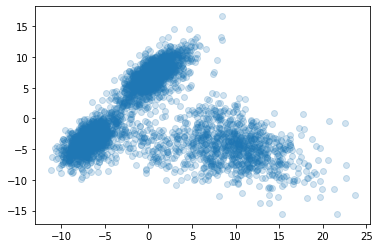

In [26]:
import matplotlib.pyplot as plt
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.2)

2-TSNE

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,verbose=1,perplexity = 40,n_iter=300)
tsne_results = tsne.fit_transform(vectorized_docs)

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3891 samples in 0.000s...
[t-SNE] Computed neighbors for 3891 samples in 0.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3891
[t-SNE] Computed conditional probabilities for sample 2000 / 3891
[t-SNE] Computed conditional probabilities for sample 3000 / 3891
[t-SNE] Computed conditional probabilities for sample 3891 / 3891
[t-SNE] Mean sigma: 4.718979
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.550003
[t-SNE] KL divergence after 300 iterations: 2.072019


c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='tsne_x_values', ylabel='tsne_y_values'>

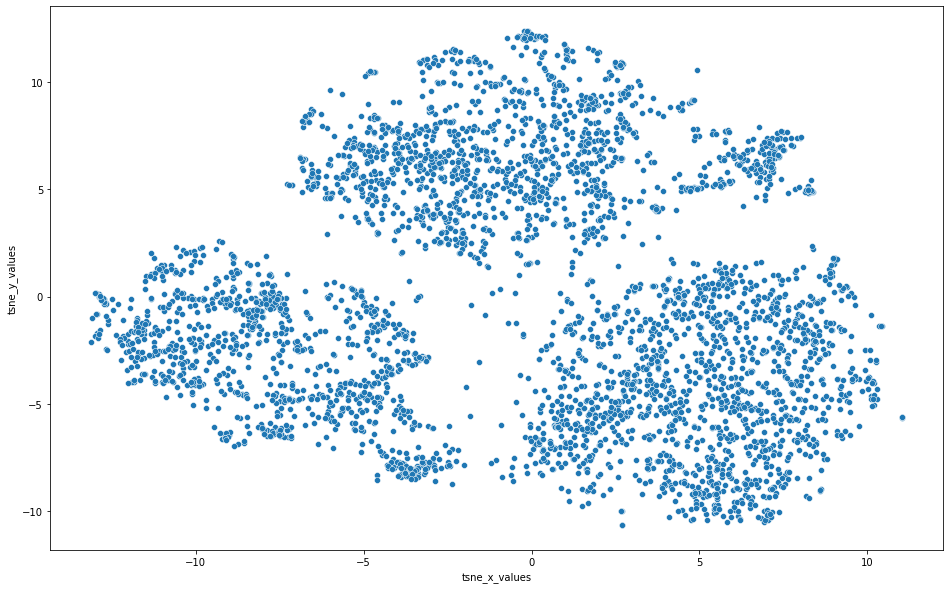

In [28]:
data_complet['tsne_x_values'] = tsne_results[:,0]
data_complet['tsne_y_values'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x_values',y='tsne_y_values',data = data_complet,
    
    palette=sns.color_palette("hls",10),
    legend=True)

<AxesSubplot:xlabel='UMAP_x_values', ylabel='UMAP_y_values'>

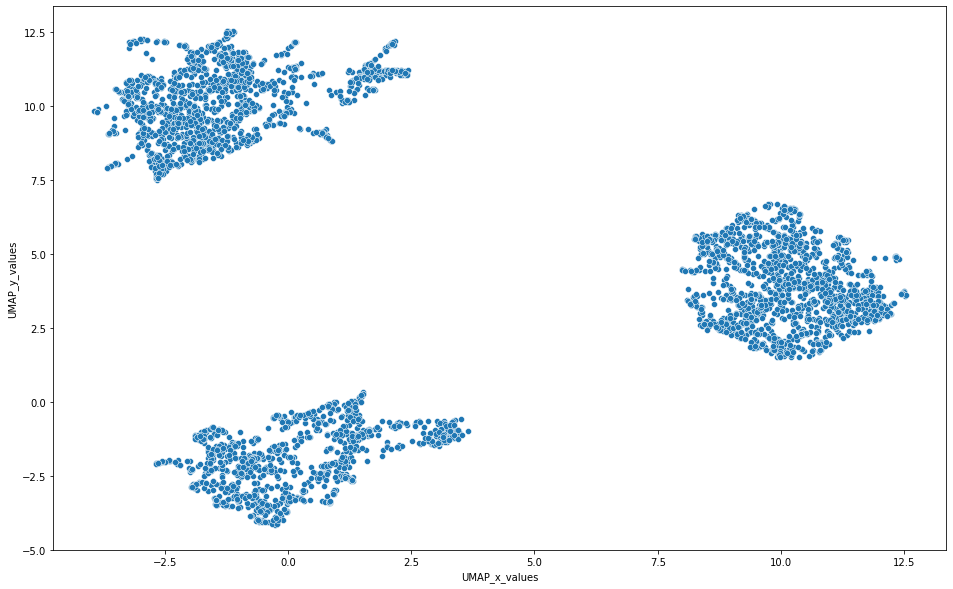

In [29]:
from sklearn.preprocessing import PowerTransformer
import umap

embedding = umap.UMAP(n_neighbors=5).fit_transform(vectorized_docs)
data_complet['UMAP_x_values'] = embedding[:,0]
data_complet['UMAP_y_values'] = embedding [:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='UMAP_x_values',y='UMAP_y_values',data = data_complet,
    
    palette=sns.color_palette("hls",10),
    legend=True)


In [30]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [31]:
input_df = Input( shape = (300, ))
x = Dense(7, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(x)
encoded = Dense(2, activation = 'relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(encoded)
x = Dense(5, activation = 'relu', kernel_initializer='glorot_uniform')(x)
decoded = Dense(300, kernel_initializer='glorot_uniform')(x)
autoencoder = Model(input_df, decoded)
encoder = Model(input_df, encoded)
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

**Note :** Cet modèle avec ces nombreux paramètres peut surajuster les données d’entraînement car il a une capacité suffisante pour le faire.On esseyant de diminuer la complexité du modèle la data était representé sur un seul axe. Plus qu'on a ajouté des paramétre plus le model à pu s'entrainer.

In [32]:
dff = pd.DataFrame(vectorized_docs)
dff.shape

(3891, 300)

In [33]:
dff.to_csv('file_name.csv', index=False)

In [34]:
autoencoder.fit(dff, dff, batch_size= 120, epochs = 20, verbose = 1)

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
33/33 [==============================] - 2s 42ms/step - loss: 0.9939
Epoch 2/20
33/33 [==============================] - 1s 43ms/step - loss: 0.9311
Epoch 3/20
33/33 [==============================] - 1s 41ms/step - loss: 0.8466
Epoch 4/20
33/33 [==============================] - 1s 39ms/step - loss: 0.8084
Epoch 5/20
33/33 [==============================] - 1s 38ms/step - loss: 0.7951
Epoch 6/20
33/33 [==============================] - 1s 38ms/step - loss: 0.7864
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.7788
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.7730
Epoch 9/20
33/33 [==============================] - 2s 52ms/step - loss: 0.7682
Epoch 10/20
33/33 [==============================] - 2s 47ms/step - loss: 0.7641
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.7594
Epoch 12/20
33/33 [==============================] - 2s 46ms/step - loss: 0.7549
Epoch 13/20
33/33 [==================

In [35]:
encode = encoder.predict(dff)
encode

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[ 5.4753895, 18.31547  ],
       [18.82409  , 14.717967 ],
       [22.652714 , 13.590904 ],
       ...,
       [ 6.8723583, 16.498173 ],
       [ 0.2915551,  0.7256518],
       [19.747042 , 10.515268 ]], dtype=float32)

<AxesSubplot:xlabel='encode_x_values', ylabel='encode_y_values'>

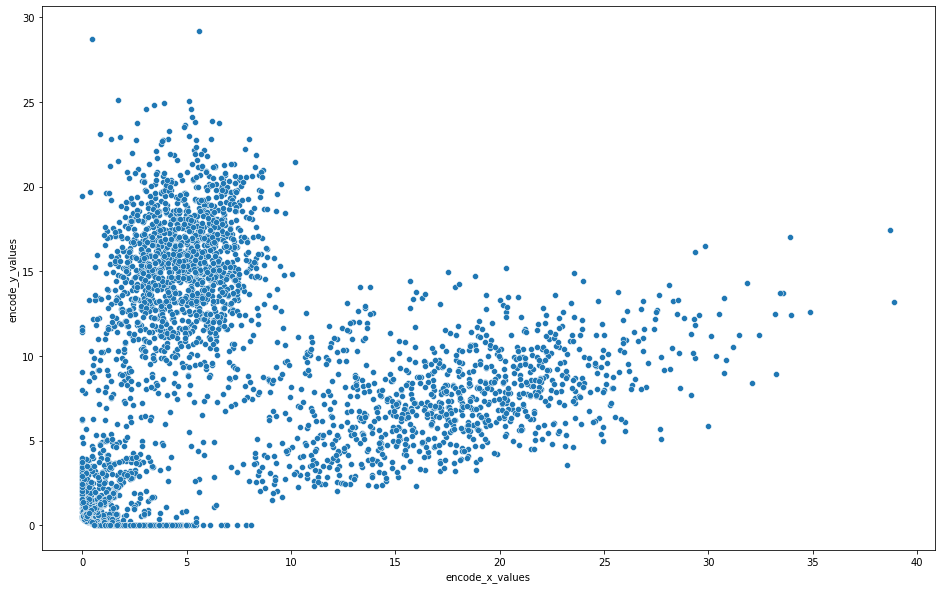

In [36]:
data_complet['encode_x_values'] = encode[:,0]
data_complet['encode_y_values'] = encode[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='encode_x_values',y='encode_y_values',data = data_complet,
    
    palette=sns.color_palette("hls",10),
    legend=True)

**Note :** Nous pouvons clairement voir que l’UMAP fait un excellent travail en séparant les points de données par rapport à t-SNE,PCA et data encoder.

In [37]:
data_complet['clusters'] = df['label']
data_complet.clusters = data_complet.clusters.map( {'cisi':0 , 'med':1, 'cran':2} )
data_complet.head()

word  PCA_x_values  \
0  milestone catalog case present study dr lehnus...     -7.247678   
1  childhood psychosis description give diagnosti...      4.368066   
2  neonatal hepatitis familial neonatal obstructi...      9.941460   
3  handbook comparative librarianship write deal ...     -9.161282   
4  design evaluation information system co join d...     -6.594983   

   PCA_y_values  tsne_x_values  tsne_y_values  UMAP_x_values  UMAP_y_values  \
0     -5.806093       3.046625      -4.239634       9.903984       1.765381   
1     -9.456207      -4.272377      -7.987103       3.072366      -1.494005   
2     -9.861764      -7.130166      -4.239796       0.860261      -1.597847   
3     -6.311701       4.335887      -6.811436      10.749321       2.528656   
4     -2.200056       6.518855      -3.469242       9.964154       3.509417   

   encode_x_values  encode_y_values  clusters  
0         5.475389        18.315470         0  
1        18.824089        14.717967         1  
2        22.652714        13.590904         1  
3         7.215262        19.360432         0  
4         3.072979        15.061749         0

**Note :** Selon la visualisation en 2D même si les algorithmes changent mais ils donnent le même resultat qui est la presence de 3 clusters.
Ce qui est proche de la realité puisque notre base de donnée contient 3 classes.

**Evaluation des algorithmes**

In [38]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from coclust.clustering import SphericalKmeans
from sklearn.cluster import AgglomerativeClustering


L'algorithme suivant va nous donner à la fin le score nmi et ari pour chaque combinaison possible des algorithmes de reduction de dimension avec les algorithmes de clusturing 

In [39]:
reduct=[pca_result,tsne_results,embedding,encode ]
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

column_names = ["kmeans", "kmedoids", "spherical", "cah"]
nmi = pd.DataFrame(columns = column_names)
ari = pd.DataFrame(columns = column_names)

for i in reduct:
    ################Kmeans fit + predict + NMI + ARI############################
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(i)
    predict2d = kmeans.predict(i)
    data_complet['kmeans_cluster'] = predict2d
    km1 = normalized_mutual_info_score(data_complet['clusters'], data_complet['kmeans_cluster'])
    km2 = adjusted_rand_score(data_complet['clusters'], data_complet['kmeans_cluster'])
    ################Kmedoids + fit + predict + NMI + ARI############################
    kmedoids = KMedoids(n_clusters=3, random_state=0).fit(i)
    predicto2d = kmedoids.predict(i)
    data_complet['kmedoids_cluster']=predicto2d
    kmd1 = normalized_mutual_info_score(data_complet['clusters'], data_complet['kmedoids_cluster'])
    kmd2 = adjusted_rand_score(data_complet['clusters'], data_complet['kmedoids_cluster'])

  ################spherical kmeans + fit + predict + NMI + ARI############################

    skm_model2d = SphericalKmeans(n_clusters=3, n_init=10)
    skm_model2d.fit(i)
    pred_skm2d = skm_model2d.labels_
    data_complet['Spherical_cluster']=pred_skm2d
    spc1 = normalized_mutual_info_score(data_complet['clusters'], data_complet['Spherical_cluster'])
    spc2 = adjusted_rand_score(data_complet['clusters'], data_complet['Spherical_cluster'])

  ################CAH + fit + predict + NMI + ARI############################
    
    agglo = AgglomerativeClustering(n_clusters = 3)
    y_pred2d = agglo.fit_predict(i)
    data_complet['CAH_cluster']=y_pred2d
    cah1 = normalized_mutual_info_score(data_complet['clusters'], data_complet['CAH_cluster'])
    cah2 = adjusted_rand_score(data_complet['clusters'], data_complet['CAH_cluster'])
  ################## Evaluation table #############################
    test1 = [km1, kmd1 ,spc1, cah1]
    nmi.loc[len(nmi)] = test1

    test2 = [km2, kmd2 ,spc2, cah2]
    ari.loc[len(ari)] = test2


 == New init == 
iteration: 0
1051.6642142793257
iteration: 1
2825.1751992742365
iteration: 2
2892.363585109602
iteration: 3
3068.45511116435
iteration: 4
3563.15524057477
iteration: 5
3723.014521273926
iteration: 6
3724.796536927757
iteration: 7
3724.800141084459
iteration: 8
3724.801007710348
iteration: 9
3724.801533806497
iteration: 10
 == New init == 
iteration: 0
951.5401338007774
iteration: 1
2824.6762989186564
iteration: 2
2900.520097297056
iteration: 3
3102.6692321369774
iteration: 4
3611.992475610482
iteration: 5
3723.5986609200263
iteration: 6
3724.796536927757
iteration: 7
3724.800141084459
iteration: 8
3724.801007710348
iteration: 9
3724.801533806497
iteration: 10
 == New init == 
iteration: 0
783.5223466684548
iteration: 1
2825.2127129373516
iteration: 2
2898.9120078505675
iteration: 3
3095.8791422816216
iteration: 4
3600.9310173520835
iteration: 5
3723.3920079758113
iteration: 6
3724.796536927757
iteration: 7
3724.800141084459
iteration: 8
3724.801007710348
iteration: 9
3

Notant que [ 0 : PCA ]-  [1 : tsne] - [ 2 : Umap] - [3 : encoder]

In [40]:
nmi

kmeans  kmedoids  spherical       cah
0  0.848984  0.859725   0.896114  0.907705
1  0.953116  0.948515   0.959656  0.948906
2  0.960578  0.960578   0.816159  0.960578
3  0.828319  0.845247   0.382597  0.918003

**Note :** NMI est une bonne mesure pour déterminer la qualité du clustering. 

1-On note qu'en appliquant UMAP pour la reduction de la dimensionnalité on a pu avoir la meilleure qualité de clustering sauf le sphérical kmeans.

2-Par contre, les données réduisent en 2D avec l'auto-encoder a la plus basse qualité de clustering entre les algorithmes de réduction.

3-L'algorithme de CAH avec n'importe quel algorithme de réduction  il a eu la meilleure qualité de clustering.

4-Spherical kmeans 3/4 de fois a eu la plus base qualité  que de clustering quelque soit les algorithme de reduction par contre en appliquant la pca il a eu le meilleur score par rapport aux autres algorithmes.


In [41]:
ari

kmeans  kmedoids  spherical       cah
0  0.889069  0.898520   0.930117  0.944004
1  0.975381  0.972063   0.979817  0.971245
2  0.980250  0.980250   0.818918  0.980250
3  0.875132  0.890781   0.372562  0.952039

**Note :** Ari est une mesure de la similitude entre deux regroupements de données.

1-2-3-4 : même remarque que NMI.



Espace d'origine

In [42]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

column_names = ["kmeans", "kmedoids", "spherical", "cah"]
nmiOr = pd.DataFrame(columns = column_names)
ariOr = pd.DataFrame(columns = column_names)

    ################Kmeans fit + predict + NMI + ARI############################
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(vectorized_docs)
kmeansP = kmeans.predict(vectorized_docs)
data_complet['kmeans_clusterOr'] = kmeansP
km21 = normalized_mutual_info_score(data_complet['clusters'], data_complet['kmeans_clusterOr'])
km22 = adjusted_rand_score(data_complet['clusters'], data_complet['kmeans_clusterOr'])
    ################Kmedoids + fit + predict + NMI + ARI############################
my_array = np.array(vectorized_docs)
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(my_array)
kmedoidsP  = kmedoids.predict(vectorized_docs)
data_complet['kmedoids_clusterOr']=kmedoidsP 
kmd21 = normalized_mutual_info_score(data_complet['clusters'], data_complet['kmedoids_clusterOr'])
kmd22 = adjusted_rand_score(data_complet['clusters'], data_complet['kmedoids_clusterOr'])

  ################spherical kmeans + fit + predict + NMI + ARI############################
skm_modelAd = SphericalKmeans(n_clusters=3, n_init=10)
skm_modelAd.fit(my_array)
spherkmP = skm_modelAd.labels_
data_complet['Spherical_clusterOr']=spherkmP 
spc21 = normalized_mutual_info_score(data_complet['clusters'], data_complet['Spherical_clusterOr'])
spc22 = adjusted_rand_score(data_complet['clusters'], data_complet['Spherical_clusterOr'])

  ################CAH + fit + predict + NMI + ARI############################
agglo = AgglomerativeClustering(n_clusters = 3)
aggloP  = agglo.fit_predict(vectorized_docs)
data_complet['CAH_clusterOr']=aggloP
cah21 = normalized_mutual_info_score(data_complet['clusters'], data_complet['CAH_clusterOr'])
cah22 = adjusted_rand_score(data_complet['clusters'], data_complet['CAH_clusterOr'])
  ################## Evaluation table #############################
test21 = [km21, kmd21 ,spc21, cah21]
nmiOr.loc[len(nmiOr)] = test21

test22 = [km22, kmd22 ,spc22, cah22]
ariOr.loc[len(ariOr)] = test22


 == New init == 
iteration: 0
350.23135201211585
iteration: 1
1284.9070799244628
iteration: 2
1456.6168251712143
iteration: 3
1659.0913729840195
iteration: 4
1855.0689833981742
iteration: 5
1860.6155873525313
iteration: 6
1860.7440707972655
iteration: 7
1860.757196315299
iteration: 8
1860.758876686608
iteration: 9
 == New init == 
iteration: 0
463.7564839795559
iteration: 1
1486.6529121792687
iteration: 2
1786.3372704383173
iteration: 3
1860.4505977802305
iteration: 4
1860.7424515587595
iteration: 5
1860.7580916297952
iteration: 6
1860.7597719232099
iteration: 7
 == New init == 
iteration: 0
461.72557881016246
iteration: 1
1700.0437593222632
iteration: 2
1859.2612154043677
iteration: 3
1860.688061999046
iteration: 4
1860.7564647367112
iteration: 5
1860.7581476453233
iteration: 6
 == New init == 
iteration: 0
545.1659538261255
iteration: 1
1551.655933650255
iteration: 2
1846.779528954375
iteration: 3
1860.7199182893173
iteration: 4
1860.7580974298503
iteration: 5
1860.7597719232099
iter

In [43]:
nmiOr

kmeans  kmedoids  spherical       cah
0  0.857505  0.522352   0.907708  0.872204

In [44]:
ariOr

kmeans  kmedoids  spherical       cah
0  0.896359  0.521447   0.940068  0.902678

**Note** : Pour les deux scores, spherical kmeans a eu le plus meilleur score par rapport aux algorithmes de clustering tandis que kmedoids a eu le plus bas score ce qui contrairement différents au résultat qu'on a obtenu en utilisant les algorithmes de reductions de dimensionnalités.

En appliquant les algorithmes de classification sans réduction préalable des dimensions n'améliorent pas les résultats. Conclusion : il est plus pértinent de résumer l'information sur la base des données et unifier les échelles avant de classifier. 

Interpretation des classes

In [45]:
def clustering_wordcloud(documents, pred_labels):
  k = len(set(pred_labels))
  fig = plt.figure(figsize = (7 * k, 5)) 

  for ind_cluster in set(pred_labels):
    ind_documents = [i for i, label in enumerate(pred_labels) if label==ind_cluster]
    cluster_texts = documents[ind_documents]
    cluster_texts = ' '.join(cluster_texts)

    plt.subplot(1, k, ind_cluster+1)
    wordcloud = WordCloud(background_color="white", max_words=40, scale=10).generate_from_text(cluster_texts)
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title("Cluster {}".format(ind_cluster))

  plt.show()

In [46]:
texts = data_complet['word'].values

In [47]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

All dimensions

Wordcloud with kmeansP


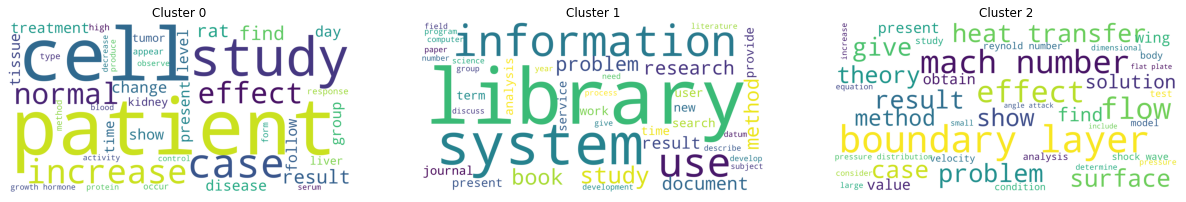

Wordcloud with kmedoidsP


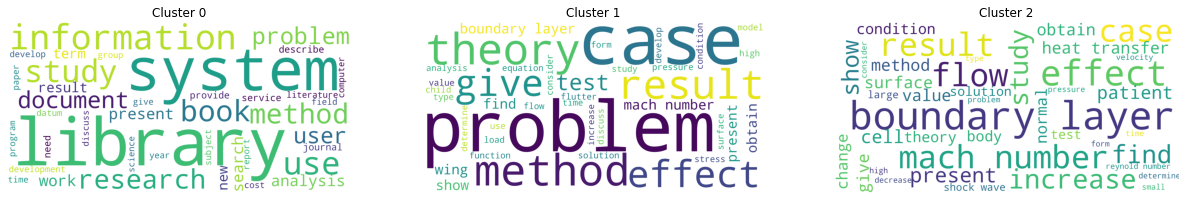

Wordcloud with spherkmP


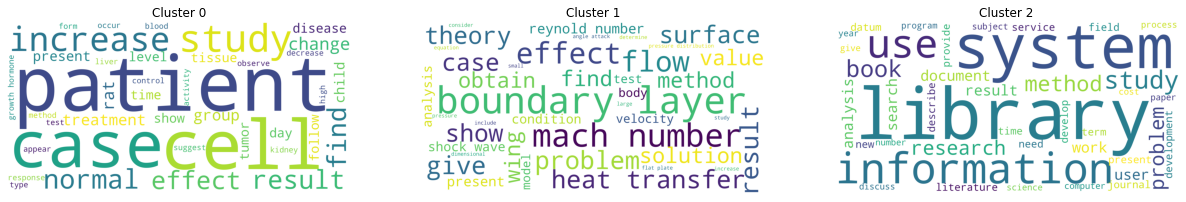

Wordcloud with aggloP


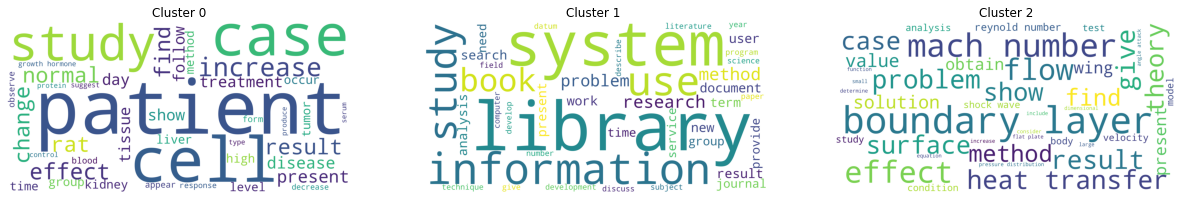

In [48]:
from wordcloud import WordCloud
origidata = [kmeansP, kmedoidsP, spherkmP, aggloP]
for i in origidata:
    a = namestr(i, globals())
    print('Wordcloud with ' + a[1])
    clustering_wordcloud(texts, i)

2D dimensions 

In [49]:
a = namestr(pca_result, globals())
a[0]

'pca_result'

In [50]:
print('Kmeans with ' + a[0])

Kmeans with pca_result


Kmeans with pca_result


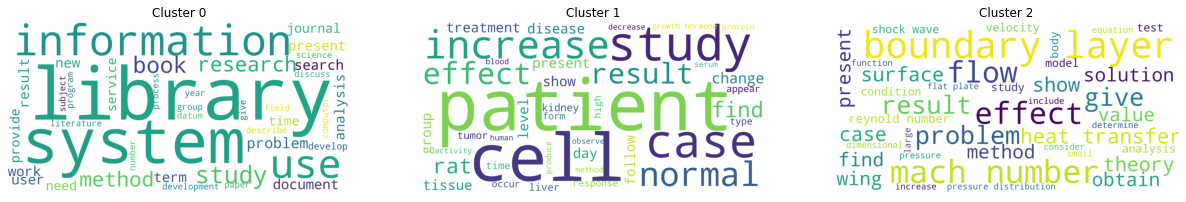

Kmedoids with pca_result


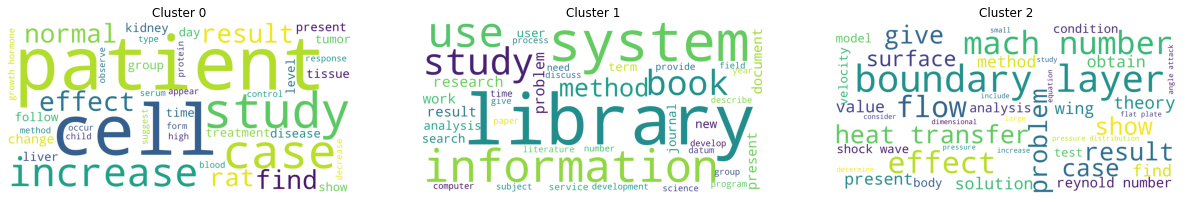

Spherical kmeans with pca_result
 == New init == 
iteration: 0
945.7873470442626
iteration: 1
2802.141043517307
iteration: 2
2872.774121502888
iteration: 3
3005.0228112983705
iteration: 4
3426.174472777249
iteration: 5
3720.2895041709053
iteration: 6
3724.7872777260436
iteration: 7
3724.800141084459
iteration: 8
3724.801007710348
iteration: 9
3724.801533806497
iteration: 10
 == New init == 
iteration: 0
1008.2025307941904
iteration: 1
2794.4125644793057
iteration: 2
2858.073368997366
iteration: 3
2947.5146086236477
iteration: 4
3257.4260252309555
iteration: 5
3702.62891825732
iteration: 6
3724.6636109587394
iteration: 7
3724.800141084459
iteration: 8
3724.801007710348
iteration: 9
3724.801533806497
iteration: 10
 == New init == 
iteration: 0
787.4882273088721
iteration: 1
2827.7421858514444
iteration: 2
2891.9634027637853
iteration: 3
3062.422874707441
iteration: 4
3549.929814445625
iteration: 5
3722.897004079501
iteration: 6
3724.796536927757
iteration: 7
3724.800141084459
iteration: 

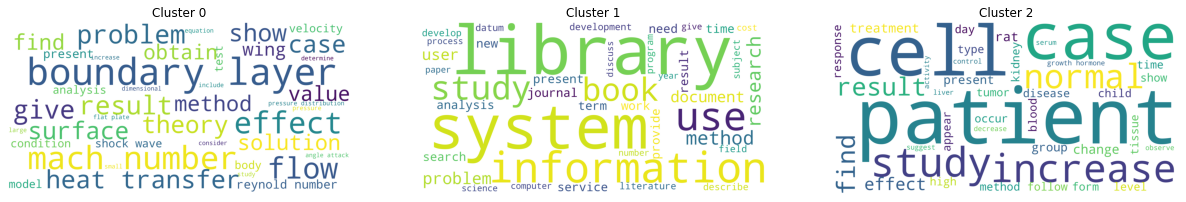

CAH with pca_result


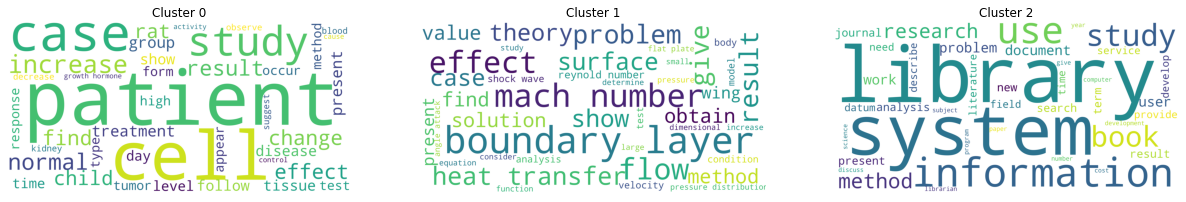

Kmeans with tsne_results


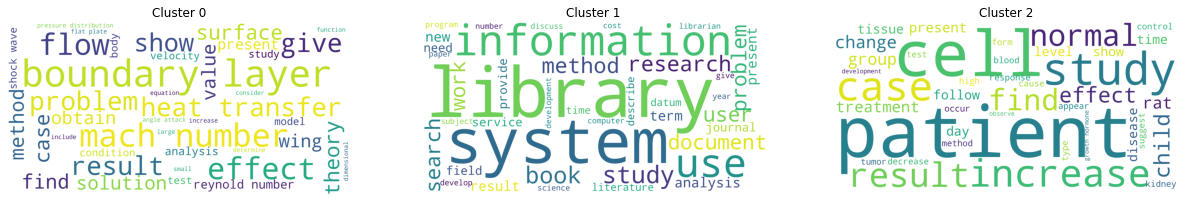

Kmedoids with tsne_results


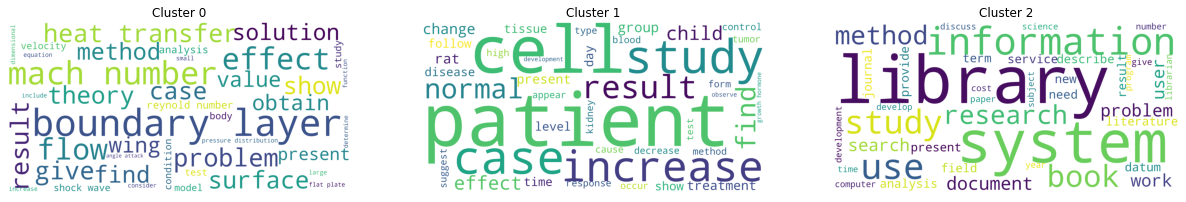

Spherical kmeans with tsne_results
 == New init == 
iteration: 0
1714.938198074152
iteration: 1
2979.1505905700324
iteration: 2
3044.8029698219752
iteration: 3
3054.232719867984
iteration: 4
3059.7929456328575
iteration: 5
3071.328691184548
iteration: 6
3106.846777711451
iteration: 7
3189.26275868291
iteration: 8
3275.7192372326863
iteration: 9
3357.763156042942
iteration: 10
3430.703921972291
iteration: 11
3465.2165702405778
iteration: 12
3469.6914048488507
iteration: 13
3469.816789735589
iteration: 14
3469.8188174741
iteration: 15
 == New init == 
iteration: 0
2922.9906700307856
iteration: 1
3177.9751367615736
iteration: 2
3276.107911293924
iteration: 3
3357.9771268723575
iteration: 4
3430.540461021441
iteration: 5
3465.121147792943
iteration: 6
3469.6736237545433
iteration: 7
3469.816789735589
iteration: 8
3469.8188174741
iteration: 9
 == New init == 
iteration: 0
2014.5371613918735
iteration: 1
3032.598725731957
iteration: 2
3136.6644873995688
iteration: 3
3271.9165810917393
iterat

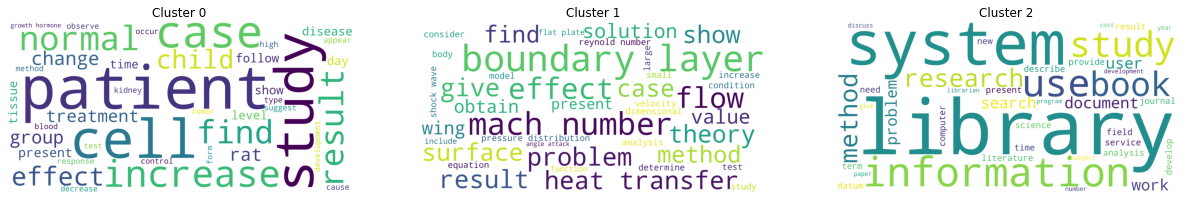

CAH with tsne_results


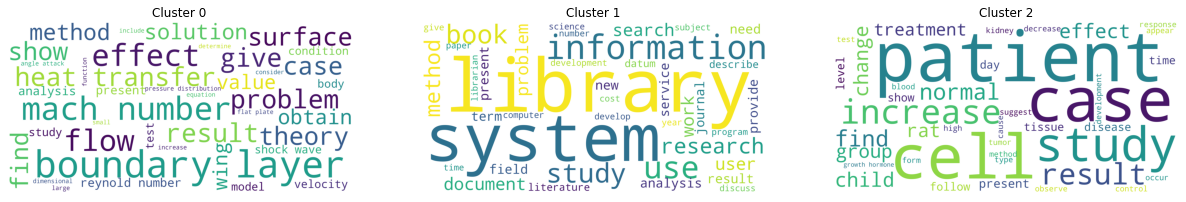

Kmeans with embedding


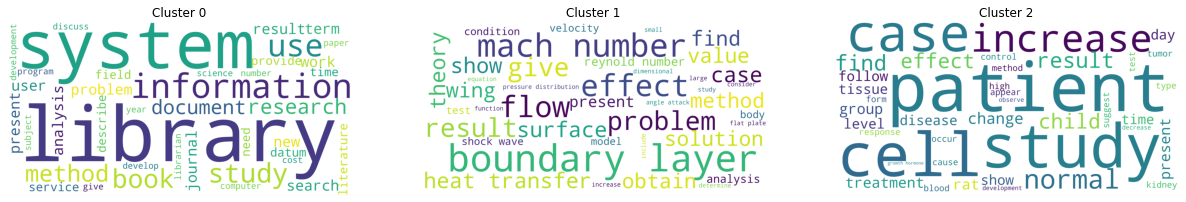

Kmedoids with embedding


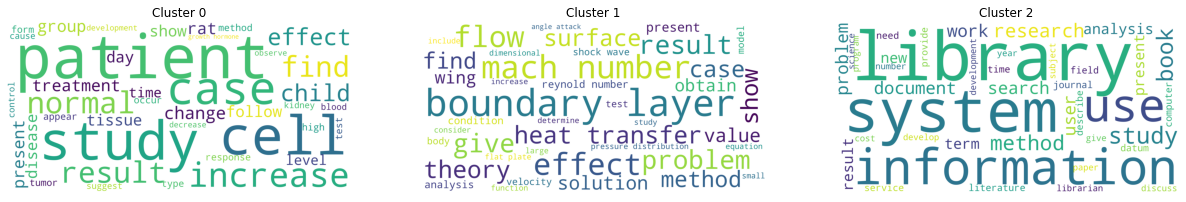

Spherical kmeans with embedding
 == New init == 
iteration: 0
1801.7414911186602
iteration: 1
3041.982810702806
iteration: 2
3667.8147263755623
iteration: 3
3717.3296503960696
iteration: 4
3720.025063024206
iteration: 5
3720.1951411275463
iteration: 6
3720.1994962682816
iteration: 7
3720.2002227682797
iteration: 8
 == New init == 
iteration: 0
1866.1701493718963
iteration: 1
3041.982810702806
iteration: 2
3667.8147263755623
iteration: 3
3717.329650396069
iteration: 4
3720.0250630242062
iteration: 5
3720.195141127547
iteration: 6
3720.1994962682816
iteration: 7
3720.2002227682797
iteration: 8
 == New init == 
iteration: 0
1802.9197883618158
iteration: 1
3041.982810702806
iteration: 2
3667.8147263755623
iteration: 3
3717.3296503960696
iteration: 4
3720.025063024206
iteration: 5
3720.1951411275463
iteration: 6
3720.1994962682816
iteration: 7
3720.2002227682797
iteration: 8
 == New init == 
iteration: 0
1851.231591542312
iteration: 1
3041.982810702806
iteration: 2
3667.8147263755623
iterat

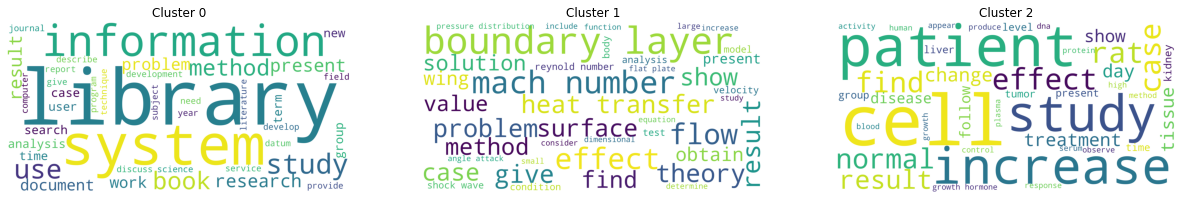

CAH with embedding


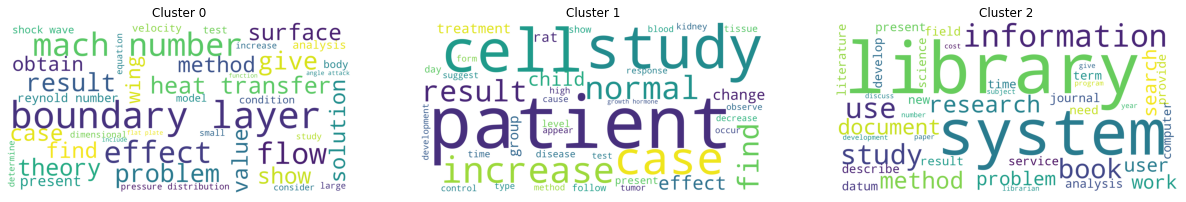

In [51]:
reduct=[pca_result,tsne_results,embedding ]
for i in reduct:
    a = namestr(i, globals())
    ################Kmeans fit + predict + NMI + ARI############################
    print('Kmeans with ' + a[0])
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(i)
    predict2d = kmeans.predict(i)
    clustering_wordcloud(texts, predict2d)
    ################Kmedoids + fit + predict + NMI + ARI############################
    print('Kmedoids with ' + a[0])
    kmedoids = KMedoids(n_clusters=3, random_state=0).fit(i)
    predicto2d = kmedoids.predict(i)
    clustering_wordcloud(texts, predicto2d)
  ################spherical kmeans + fit + predict + NMI + ARI############################
    print('Spherical kmeans with ' + a[0])
    skm_model2d = SphericalKmeans(n_clusters=3, n_init=10)
    skm_model2d.fit(i)
    pred_skm2d = skm_model2d.labels_
    clustering_wordcloud(texts, pred_skm2d)
  ################CAH + fit + predict + NMI + ARI############################
    print('CAH with ' + a[0])
    agglo = AgglomerativeClustering(n_clusters = 3)
    y_pred2d = agglo.fit_predict(i)    
    clustering_wordcloud(texts,  y_pred2d)


**Note :** 

On retient qu'il y a 3 classes. Une première classe est dominée par les mots liée à la recherche en médecine, la deuxième est axée sur les sciences physiques et la troisième est centrée sur les sciences d'information.

Le word cloud associé au algorithmes avec un score plus élevé contient des nombreux mots de grandes tailles et ces mots expriment bien la classe, tandis que pour le word cloud associé au algorithmes avec un score plus bas contient des mots de même taille et pas tous expriment la classe associée.



**Partie 1-3 : L'étude sur l’estimation du nombre de classes par le package NbClust est disponible sur le fichier R.**

In [52]:
%%R 
library('NbClust')

In [54]:
%R -i my_array

In [55]:
%%R 
diss_matrix <-  dist(my_array, method = "euclidean", diag = FALSE)

In [56]:
%%R
res <- NbClust(my_array, diss = diss_matrix, distance = NULL, min.nc = 2, max.nc = 10,method = "complete", index = "duda")

All 3891 observations were used. 
 


In [57]:
%%R
res$All.index

     2      3      4      5      6      7      8      9     10 
0.8933 0.8805 1.0002 0.9199 1.0004 0.9827 0.9327 0.7887 1.0001 


In [58]:
%%R
res$Best.nc

Number_clusters     Value_Index 
         4.0000          1.0002 


On remarque que 4 est le meilleur nombre du clusters et le nombre de cluster 3 arrivant au septième place


**Partie 2**

  |======================================================================| 100%

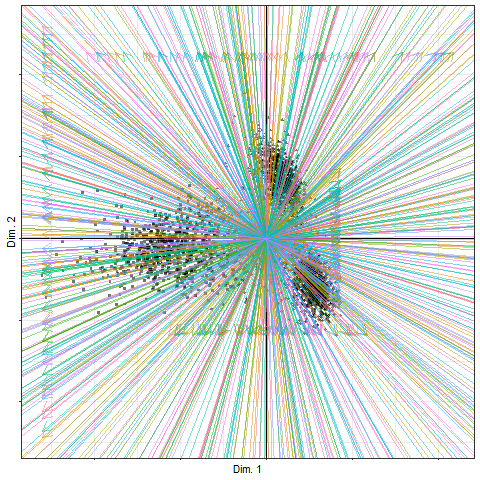

In [60]:
%%R 
library('clustrd')
#Reduced kmeans with 3 clusters in 2 dimensions after 10 random starts
outRKM = cluspca(my_array,3,2, method="RKM", rotation ="varimax", scale=FALSE, nstart=10)
#Scatterplot (dimensions 1 and 2) and cluster description plot
plot(outRKM, clusdesc = TRUE)

On note 3 clusters d'où 2 sont condensés tandis que les données dans le troisième cluster sont plus dispersés.

In [61]:
%%R
predRKM = outRKM$cluster

In [62]:
%R -o predRKM

In [63]:
from sklearn.metrics import accuracy_score

In [64]:
#Evaluation du Reduced kmeans
NMI = round(normalized_mutual_info_score(data_complet['clusters'], predRKM),6)
ARI = round(adjusted_rand_score(data_complet['clusters'], predRKM),6)

In [65]:
evaluate={'NMI_score':NMI, 'ARI_score': ARI}
evaluate

{'NMI_score': 0.857505, 'ARI_score': 0.896359}

On générale les deux scores sont élevés mais la réduction de dimensionnalité plus les algorithmes de clustering ont donné un meilleur résultat 

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
X_w2v_scaled = StandardScaler().fit_transform(my_array)

In [68]:
%R -i X_w2v_scaled

In [69]:
%%R 
library('clustrd')
#Factorial K-means with 3 clusters in 2 dimensions
#with a Reduced K-means starting solution

outFKM = cluspca(X_w2v_scaled, 3, 2, method = "FKM", rotation = "varimax", scale = FALSE, smartStart = predRKM)
outFKM

  |======================================================================| 100%Solution with 3 clusters of sizes 2090 (53.7%), 1443 (37.1%), 358 (9.2%) in 2 dimensions. Variables were mean centered and unstandardized.

Cluster centroids:
            Dim.1   Dim.2
Cluster 1  2.2877  0.1385
Cluster 2 -3.2754 -2.0304
Cluster 3 -0.1533  7.3752

Variable scores:
      Dim.1   Dim.2
1   -0.0177 -0.0970
2    0.0773  0.0929
3   -0.0514 -0.0167
4   -0.0914 -0.0033
5   -0.0809 -0.0432
6   -0.0747  0.0104
7   -0.0577 -0.0523
8   -0.0944 -0.0302
9   -0.0307 -0.0042
10   0.1186 -0.0171
11   0.0082 -0.0591
12  -0.0552 -0.0860
13   0.0268 -0.0030
14  -0.0186 -0.0079
15   0.0353 -0.0229
16  -0.0350  0.0391
17  -0.0796 -0.0574
18   0.0089  0.1197
19   0.0026 -0.0430
20   0.0283  0.0800
21  -0.0305  0.0321
22   0.0283 -0.1080
23  -0.0011  0.0648
24  -0.0076 -0.0117
25   0.0360 -0.1011
26  -0.0435 -0.0445
27  -0.0480 -0.0555
28   0.0025 -0.0526
29   0.0495 -0.0323
30  -0.0183  0.0153
31  -0.1031  0.0313


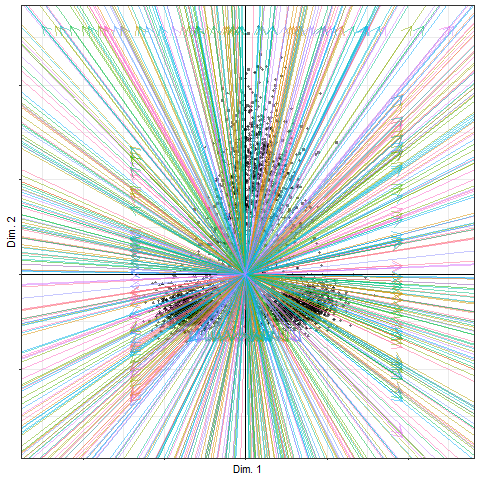

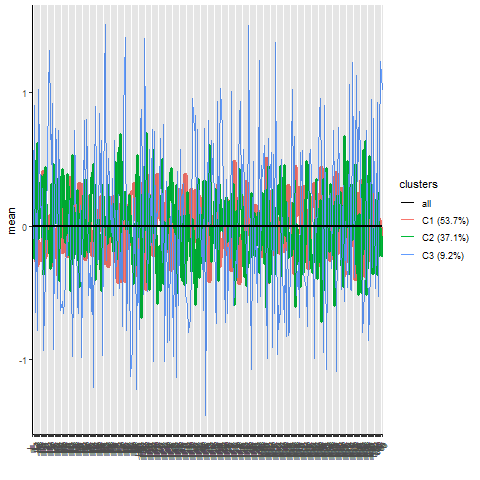

In [70]:
%%R
#Scatterplot (dimensions 1 and 2) and cluster description plot
plot(outFKM, cludesc = TRUE)

In [71]:
%%R
outFKM = outFKM$cluster

In [72]:
%R -o outFKM

In [73]:
#Evaluation du Reduced kmeans
NMI = round(normalized_mutual_info_score(data_complet['clusters'], outFKM),6)
ARI = round(adjusted_rand_score(data_complet['clusters'], outFKM),6)

In [74]:
evaluate={'NMI_score':NMI, 'ARI_score': ARI}
evaluate

{'NMI_score': 0.177352, 'ARI_score': 0.160003}

NOTE : On utilisant le  FKM le resultat des scores NMI et ARI est très faible


D'appres les resultats obtenue du premiere et deuxieme partie reduction de dimension apres algorithmes de clustering reste la meilleure tecniques apres RKM et faire le clustering sans reductions de dimmension donnent un resultat presuqe similaire